# Autoencoderサンプル(Pytorch)
作成日2021/05/07


In [1]:
import numpy as np
import csv
import pandas as pd
root_path = "Obrid_AE/test_data/"
test_data_path = root_path + "data0503.csv"
#---------------CSVから読み取る----------------------------
data_df = pd.read_csv(test_data_path, engine="python")
data = data_df.values
#---------------CSVから読み取る----------------------------
print(data.shape)
print(data[0])
#Numpy形式で保存https://note.nkmk.me/python-numpy-load-save-savez-npy-npz/
np.save(root_path + "np_data", data)

(503, 256)
[168 168 168 172 176 180 182 184 186 182 194 194 196 200 204 202 204 210
 214 220 214 222 224 226 226 234 234 232 232 234 236 242 238 242 246 240
 242 244 248 244 248 248 242 248 228 208 232 246 240 244 238 240 236 236
 238 236 240 232 232 238 238 236 226 232 246 238 240 246 252 238 206 252
 260 250 248 250 250 258 256 258 260 260 262 264 264 270 272 272 280 280
 280 286 286 284 286 290 294 294 294 294 302 300 300 302 300 302 306 304
 316 316 312 318 320 330 338 344 336 290 244 260 322 360 360 340 334 328
 330 334 326 328 330 334 340 326 320 326 330 328 332 334 332 334 334 328
 332 332 334 334 330 330 338 334 334 336 332 326 332 338 332 328 334 334
 322 312 320 322 314 284 280 310 306 306 304 302 298 302 294 282 288 286
 292 294 292 290 288 286 292 292 288 292 296 298 302 306 312 314 310 314
 310 310 322 332 322 324 334 330 340 342 342 342 346 348 354 354 356 360
 364 358 364 366 368 372 372 378 372 374 374 386 390 388 392 386 394 384
 392 400 400 398 398 396 396 396 402 402

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
#---------------Numpy形式から読み取る----------------------------
data = np.load(root_path + "np_data" + ".npy")
print(data.max(), data.min())
data = (data - data.min()) / (data.max() - data.min())
#---------------Numpy形式から読み取る----------------------------
#エポック数とエポック自体のサイズ
epoch_num = 100
epoch_size = 300
list=[]
for i in range(epoch_num):
    #ランダムに配列の番号をランダムに指定
    make_epoch = np.random.randint(0, len(data), (epoch_size))
    #ランダムに指定した番号のデータを選択、リストに追加
    list.append(data[make_epoch, :])
test_data = np.array(list)
# conv1を適用するために３次元
test_data = test_data[:, :, np.newaxis, np.newaxis, :]
# test_data = np.array(list)/1024
test_data.shape

1148 0


(100, 300, 1, 1, 256)

In [27]:
data.shape

(503, 256)

##  一次元CNN
カーネルのサイズとか色々変えながらやってみてください。
前結合層も組み込もうとしてたけど、あまり具合が良くなさそうだったためコメントアウトしてます。
丸め誤差的なので出力サイズが256にならない現象が起きてるので、output_paddingなど追加した、ここら辺のパラメタを使えば埋め合わせができる

In [11]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #N(バッチサイズ), 784(ピクセル数64x64)
#         self.encoder = nn.Sequential(
#             nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5),
#             # nn.MaxPool1d(kernel_size=5, stride= 3)
#             nn.ReLU(),
#             nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3),
#             # nn.ReLU(),
#             # nn.Flatten(0, -1),
#             # nn.Linear(16, 12), #N,64 -> N,12
#             # nn.ReLU(),
#             # nn.Linear(12, 3), #N,12 -> N,3
#         )
#         self.decoder = nn.Sequential(
#             # nn.Linear(3, 12), #N,784 -> N,128
#             # nn.ReLU(),
#             # nn.Linear(12, 16), #N,128 -> N,64
#             # nn.ReLU(),
#             # nn.Unflatten(0, (1, 1 ,16)),
#             nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5, padding = 1, output_padding=1),
#             # nn.Flatten(0, -1),
#             # nn.ReLU(),
#             nn.Sigmoid(),
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

## 前結合層あり一次元CNN

In [28]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        #N(バッチサイズ), 784(ピクセル数64x64)
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5),
            # nn.MaxPool1d(kernel_size=5, stride= 3)
            nn.ReLU(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3),
            nn.ReLU(),
            nn.Flatten(0, -1),
            # nn.Linear(16, 12), #N,16 -> N,12
            # nn.ReLU(),
            # nn.Linear(12, 3), #N,12 -> N,3\
            nn.Linear(16, 3), #N,16 -> N,12
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,  16),
            # nn.Linear(3, 12), #N,784 -> N,128
            # nn.ReLU(),
            # nn.Linear(12, 16), 
            nn.ReLU(),
            nn.Unflatten(0, (1, 1 ,16)),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5, stride = 3, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 7, stride = 5, padding = 1, output_padding=1),
            # nn.Flatten(0, -1),
            # nn.ReLU(),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 学習

In [29]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
for epoch in test_data:
    for data in epoch:
        recon = model(data)
        print(recon.shape, data.shape)
        loss = criterion(recon, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, data, recon))

([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
to

.01741607 0.00703279 0.00445539 0.00090122
 0.0009191  0.00094339 0.00123695 0.00134488 0.00214085 0.00217735
 0.00222677 0.00211727 0.00198884 0.00181093 0.00184278 0.00188594
 0.00416642 0.00582825 0.02274576 0.02295657 0.0232395  0.01937751
 0.01739917 0.01261053 0.01275237 0.01294318 0.01390253 0.01401951
 0.01581526 0.0159812  0.01620422 0.01846168 0.01917697 0.02395987
 0.0241777  0.02446999 0.02063552 0.01863621 0.01377821 0.01392912
 0.01413207 0.01512119 0.01523075 0.0170686  0.01724332 0.01747809
 0.01995964 0.02076787 0.02605259 0.02628202 0.02658978 0.02256162
 0.0204484  0.0152819  0.01544399 0.01566189 0.01671779 0.01683285
 0.01878717 0.01897343 0.0192236  0.02184801 0.02269761 0.02823924
 0.02848016 0.02880321 0.02586201 0.02409602 0.01989379 0.02008719
 0.02034688 0.0213251  0.02132912 0.02306769 0.02328038 0.02356582
 0.0276282  0.02917246 0.03827854 0.03856501 0.03894866 0.03501042
 0.03271285 0.0270607  0.02729551 0.02761042 0.0288764  0.02892109
 0.03117308 0.03142

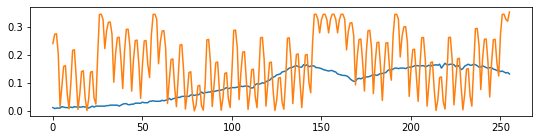

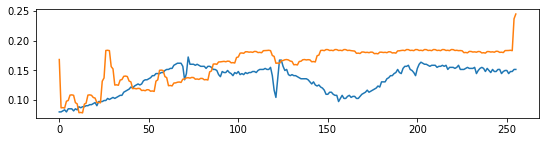

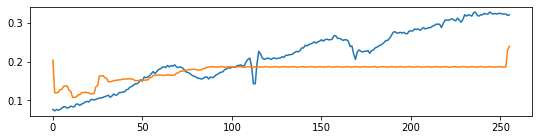

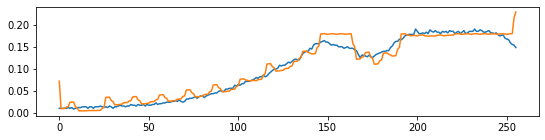

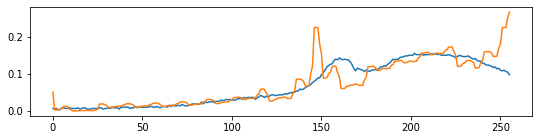

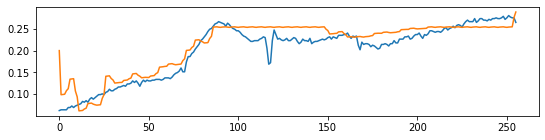

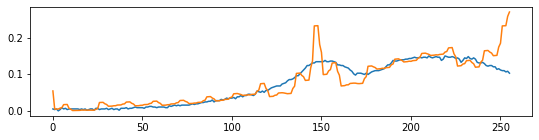

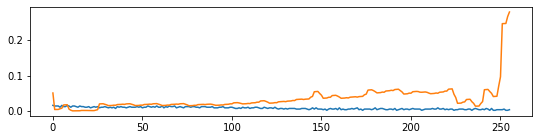

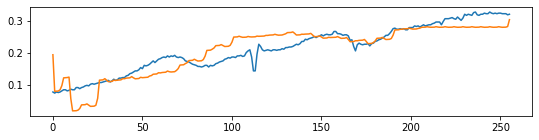

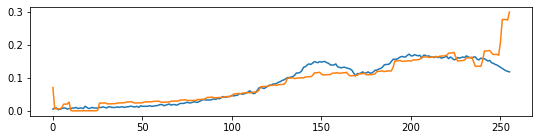

In [30]:
for k in range(0, epoch_num, int(epoch_num/10)):
    plt.figure(figsize=(9, 2))
    datas = outputs[k][1].flatten().detach().numpy()
    recon = outputs[k][2].flatten().detach().numpy()
    print(data.flatten())
    print(recon.flatten())
    plt.plot(datas)
    plt.plot(recon)

## 異常検知

In [31]:
#データの読み込み
test_path = "Obrid_AE/test_data/test0503.csv"
test_df = pd.read_csv(test_path, engine="python").values
# test = test_df.values
# test = test_df.values/1024
test = (test_df - test_df.min()) / (test_df.max() - test_df.min())
print(test.shape)
print(test[0])
data_path = "Obrid_AE/test_data/data0503.csv"
data_df = pd.read_csv(data_path, engine="python").values
# Data = data_df.values
# Data = data_df.values/1024
Data = (data_df - data_df.min()) / (data_df.max() - data_df.min())
print(Data.shape)
print(Data[0])

(99, 256)
[0.01022495 0.01431493 0.01226994 0.01635992 0.01226994 0.01226994
 0.01431493 0.01226994 0.01431493 0.01431493 0.01431493 0.01226994
 0.01635992 0.01431493 0.01226994 0.01635992 0.01226994 0.01431493
 0.01226994 0.01022495 0.01635992 0.01226994 0.01431493 0.01635992
 0.01431493 0.01226994 0.01022495 0.01022495 0.01226994 0.01431493
 0.01431493 0.01022495 0.01431493 0.01635992 0.01022495 0.01431493
 0.01226994 0.01226994 0.01226994 0.01226994 0.01431493 0.01431493
 0.01431493 0.01431493 0.01022495 0.01431493 0.01226994 0.01431493
 0.01431493 0.01022495 0.01431493 0.01226994 0.01431493 0.01226994
 0.01635992 0.01431493 0.01226994 0.01431493 0.01226994 0.01226994
 0.01431493 0.01431493 0.01226994 0.01226994 0.01226994 0.01431493
 0.01431493 0.01431493 0.01431493 0.01635992 0.01431493 0.01226994
 0.01635992 0.01226994 0.01635992 0.01226994 0.01431493 0.01226994
 0.01431493 0.01431493 0.01226994 0.01226994 0.01226994 0.01226994
 0.01226994 0.01226994 0.01431493 0.01431493 0.01226

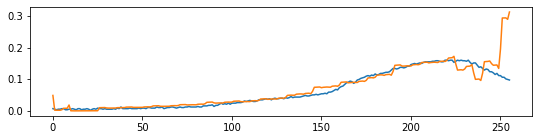

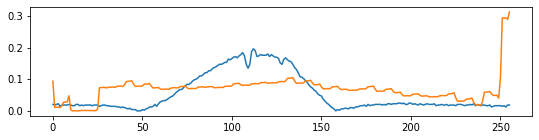

In [37]:
num = 50
data0 =  torch.from_numpy((Data[num]).astype(np.float32)).clone()
test0 =  torch.from_numpy((test[num]).astype(np.float32)).clone()

plt.figure(figsize=(9, 2))
# data = data0.numpy()
data = data0[np.newaxis, np.newaxis, :]
recon = model(data).detach().numpy()
plt.plot(data0.numpy())
plt.plot(recon.flatten())
plt.show()

plt.figure(figsize=(9, 2))
# data = test0.numpy()
data = test0[np.newaxis, np.newaxis, :]
recon = model(data).detach().numpy()
plt.plot(test0.numpy())
plt.plot(recon.flatten())